## Stable Diffusion (Text to Image) - Finetune with images of Pokemon (large dataset)

#### Imports 

In [2]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.utils import name_from_base
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from sagemaker import hyperparameters
from sagemaker import script_uris
from sagemaker import image_uris
from sagemaker import model_uris
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import datetime
import logging
import boto3
import json
import os

##### Setup logging 

In [3]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

##### Log versions of dependencies 

In [4]:
logger.info(f'[Using sageMaker version: {sagemaker.__version__}]')

[Using sageMaker version: 2.120.0]


#### I. Setup essentials 

In [5]:
ROLE = get_execution_role()
REGION = boto3.Session().region_name
session = sagemaker.Session()
logger.info(f'Region: {REGION}')

Region: us-east-1


##### List all models from SageMaker JumpStart hub

In [6]:
models = list_jumpstart_models()
len(models)

524

In [7]:
FILTER = 'task == txt2img'
txt2img_models = list_jumpstart_models(filter=FILTER)
txt2img_models

['model-txt2img-stabilityai-stable-diffusion-v1-4',
 'model-txt2img-stabilityai-stable-diffusion-v1-4-fp16',
 'model-txt2img-stabilityai-stable-diffusion-v2',
 'model-txt2img-stabilityai-stable-diffusion-v2-1-base',
 'model-txt2img-stabilityai-stable-diffusion-v2-fp16']

In [8]:
MODEL_ID = 'model-txt2img-stabilityai-stable-diffusion-v2-1-base'
MODEL_VERSION = '*'  # latest
SCOPE = 'training'
TRAIN_INSTANCE_TYPE = 'ml.g4dn.2xlarge'

#### II. Retrieve training artifacts 

In [9]:
train_image_uri = image_uris.retrieve(region=REGION, 
                                      framework=None,
                                      model_id=MODEL_ID, 
                                      model_version=MODEL_VERSION, 
                                      image_scope=SCOPE, 
                                      instance_type=TRAIN_INSTANCE_TYPE)
logger.info(f'Training image URI: {train_image_uri}')

image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
Training image URI: 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04


In [10]:
train_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                        model_version=MODEL_VERSION, 
                                        script_scope=SCOPE)
logger.info(f'Training source URI: {train_source_uri}')

Training source URI: s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/transfer_learning/txt2img/v1.0.0/sourcedir.tar.gz


In [11]:
train_model_uri = model_uris.retrieve(model_id=MODEL_ID, 
                                      model_version=MODEL_VERSION, 
                                      model_scope=SCOPE)
logger.info(f'Training model URI: {train_model_uri}')

Training model URI: s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-stabilityai-stable-diffusion-v2-1-base.tar.gz


##### Setup data locations 

In [12]:
DEFAULT_BUCKET = session.default_bucket()
logger.info(f'Default bucket = {DEFAULT_BUCKET}')

Default bucket = sagemaker-us-east-1-119174016168


In [13]:
TRAIN_DATA_INPUT_PREFIX = 'js-input/pokemon/'

In [14]:
TRAIN_DATA_INPUT_S3_PATH = f's3://{DEFAULT_BUCKET}/{TRAIN_DATA_INPUT_PREFIX}'
logger.info(f'Training data input S3 location => {TRAIN_DATA_INPUT_S3_PATH}')

Training data input S3 location => s3://sagemaker-us-east-1-119174016168/js-input/pokemon/


#### III. Copy dataset for fine-tuning from local to S3

In [15]:
!rm -rf ./data/.ipynb_checkpoints/ 

In [16]:
%%capture 

!aws s3 cp ./data {TRAIN_DATA_INPUT_S3_PATH} --recursive

In [17]:
TRAIN_DATA_OUTPUT_PREFIX = 'js-output'
TRAIN_DATA_OUTPUT_S3_PATH = f's3://{DEFAULT_BUCKET}/{TRAIN_DATA_OUTPUT_PREFIX}'
logger.info(f'Training output S3 location => {TRAIN_DATA_OUTPUT_S3_PATH}')

Training output S3 location => s3://sagemaker-us-east-1-119174016168/js-output


#### IV. Access and update default hyperparams

In [18]:
hyperparams = hyperparameters.retrieve_default(model_id=MODEL_ID, 
                                               model_version=MODEL_VERSION)
hyperparams 

{'epochs': '20',
 'max_steps': 'None',
 'batch_size': '1',
 'with_prior_preservation': 'False',
 'num_class_images': '100',
 'learning_rate': '2e-06',
 'prior_loss_weight': '1.0',
 'center_crop': 'False',
 'lr_scheduler': 'constant',
 'adam_weight_decay': '0.01',
 'adam_beta1': '0.9',
 'adam_beta2': '0.999',
 'adam_epsilon': '1e-08',
 'gradient_accumulation_steps': '1',
 'max_grad_norm': '1.0',
 'seed': '0'}

You can also override these hyperparams 

In [19]:
hyperparams['max_steps'] = '400'
hyperparams['seed'] = '123'
hyperparams

{'epochs': '20',
 'max_steps': '400',
 'batch_size': '1',
 'with_prior_preservation': 'False',
 'num_class_images': '100',
 'learning_rate': '2e-06',
 'prior_loss_weight': '1.0',
 'center_crop': 'False',
 'lr_scheduler': 'constant',
 'adam_weight_decay': '0.01',
 'adam_beta1': '0.9',
 'adam_beta2': '0.999',
 'adam_epsilon': '1e-08',
 'gradient_accumulation_steps': '1',
 'max_grad_norm': '1.0',
 'seed': '123'}

#### V. Finetune Stable Diffusion model

In [20]:
model_prefix = name_from_base(f'js-{MODEL_ID}-')
training_job_name = f'{model_prefix}-finetuning'
logger.info(f'Train job name => {training_job_name}')

Train job name => js-model-txt2img-stabilityai-stable-dif-2023-02-14-17-40-58-095-finetuning


In [21]:
MAX_RUN = 360000

In [22]:
estimator = Estimator(role=ROLE, 
                      image_uri=train_image_uri, 
                      source_dir=train_source_uri, 
                      model_uri=train_model_uri, 
                      entry_point='transfer_learning.py', 
                      instance_count=1, 
                      instance_type=TRAIN_INSTANCE_TYPE, 
                      max_run=MAX_RUN, 
                      hyperparameters=hyperparams, 
                      output_path=TRAIN_DATA_OUTPUT_S3_PATH, 
                      base_job_name=training_job_name)

In [23]:
%%time

estimator.fit({'training': TRAIN_DATA_INPUT_S3_PATH}, logs=False)

Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Creating training-job with name: js-model-txt2img-stabilityai-stable-dif-2023-02-14-17-40-58-340
train request: {
    "AlgorithmSpecification": {
        "TrainingInputMode": "File",
        "TrainingImage": "763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04"
    },
    "OutputDataConfig": {
        "S3OutputPath": "s3://sagemaker-us-east-1-119174016168/js-output"
    },
    "TrainingJobName": "js-model-txt2img-stabilityai-stable-dif-2023-02-14-17-40-58-340",
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
    "ResourceConfig": {
        "VolumeSizeInGB": 30,
        "InstanceCount": 1,
        "InstanceType": "ml.g4dn.2xlarge"
    },
    "RoleArn": "arn:aws:iam::119174016168:role/service-role/AmazonSageMaker-ExecutionRole-20211014T093628",
    "InputDataConfig": [
        {
 


2023-02-14 17:40:58 Starting - Starting the training job....
2023-02-14 17:41:19 Starting - Preparing the instances for training..........
2023-02-14 17:42:15 Downloading - Downloading input data.....................................................................
2023-02-14 17:48:12 Training - Training image download completed. Training in progress........................................................................................................................................
2023-02-14 17:59:35 Uploading - Uploading generated training model..................................................................................................................
2023-02-14 18:09:21 Completed - Training job completed
CPU times: user 1.59 s, sys: 175 ms, total: 1.76 s
Wall time: 28min 23s


#### VI. Deploy fine-tuned model as a SageMaker endpoint

##### Retrieve artifacts for inference 

In [24]:
SCOPE = 'inference'
INFERENCE_INSTANCE_TYPE = 'ml.g4dn.2xlarge'  # preferred

In [25]:
deploy_image_uri = image_uris.retrieve(region=REGION, 
                                       framework=None,  
                                       image_scope=SCOPE, 
                                       model_id=MODEL_ID, 
                                       model_version=MODEL_VERSION, 
                                       instance_type=INFERENCE_INSTANCE_TYPE)
logger.info(f'Deploy image URI => {deploy_image_uri}')

Deploy image URI => 763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04


In [26]:
deploy_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                         model_version=MODEL_VERSION, 
                                         script_scope=SCOPE)
logger.info(f'Deploy source URI => {deploy_source_uri}')

Deploy source URI => s3://jumpstart-cache-prod-us-east-1/source-directory-tarballs/stabilityai/inference/txt2img/v1.2.1/sourcedir.tar.gz


In [27]:
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
endpoint_name = f'js-ep-{current_time}'
endpoint_name

'js-ep-20230214180921'

In [28]:
%%time

predictor = estimator.deploy(initial_instance_count=1, 
                             instance_type=INFERENCE_INSTANCE_TYPE, 
                             entry_point='inference.py', 
                             image_uri=deploy_image_uri, 
                             source_dir=deploy_source_uri, 
                             endpoint_name=endpoint_name)

Creating model with name: sagemaker-jumpstart-2023-02-14-18-09-21-913
CreateModel request: {
    "ModelName": "sagemaker-jumpstart-2023-02-14-18-09-21-913",
    "ExecutionRoleArn": "arn:aws:iam::119174016168:role/service-role/AmazonSageMaker-ExecutionRole-20211014T093628",
    "PrimaryContainer": {
        "Image": "763104351884.dkr.ecr.us-east-1.amazonaws.com/huggingface-pytorch-inference:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04",
        "Environment": {
            "SAGEMAKER_PROGRAM": "inference.py",
            "SAGEMAKER_SUBMIT_DIRECTORY": "/opt/ml/model/code",
            "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
            "SAGEMAKER_REGION": "us-east-1"
        },
        "ModelDataUrl": "s3://sagemaker-us-east-1-119174016168/sagemaker-jumpstart-2023-02-14-18-09-21-913/model.tar.gz"
    },
    "Tags": [
        {
            "Key": "aws-jumpstart-training-model-uri",
            "Value": "s3://jumpstart-cache-prod-us-east-1/stabilityai-training/train-model-txt2img-st

----------!CPU times: user 6min 25s, sys: 1min 1s, total: 7min 27s
Wall time: 13min 27s


#### VII. Invoke the endpoint for inference using Predictor 

In [29]:
prompt = 'pokemon riding a car'

In [30]:
prompt = json.dumps(prompt).encode('utf-8')

In [31]:
MIME_INFO = {'ContentType': 'application/x-text', 
             'Accept': 'application/json'}

In [32]:
%%time

response = predictor.predict(prompt, MIME_INFO)

CPU times: user 18.1 ms, sys: 12.3 ms, total: 30.4 ms
Wall time: 24.9 s


In [33]:
response = json.loads(response)

In [34]:
img = response['generated_image']
prompt = response['prompt']

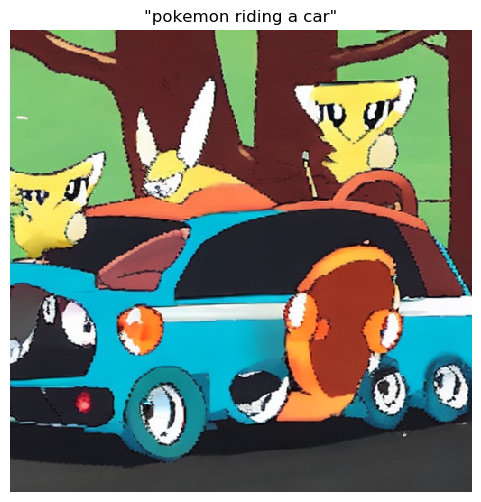

In [35]:
plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.title(prompt)
plt.show()

VIII. Invoke the endpoint for inference using SageMaker run-time client (Alternative approach)

In [37]:
client = boto3.client('sagemaker-runtime')

In [38]:
prompt = 'pokemon style car'

In [40]:
%%time 

response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                  Body=prompt, 
                                  ContentType='application/x-text')

CPU times: user 15 ms, sys: 325 µs, total: 15.3 ms
Wall time: 24.5 s


In [41]:
response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

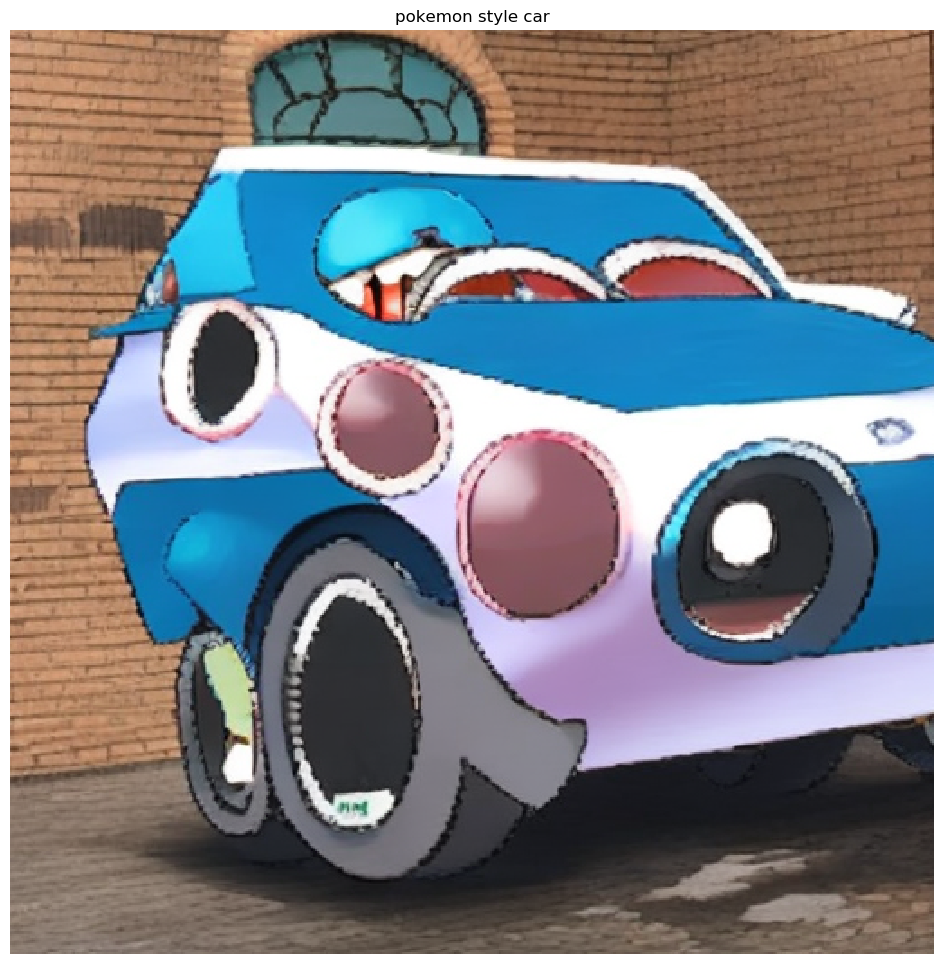

In [42]:
plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()